## Viewing and exploring overlapping labels

In this notebook we use the ```napari-segment-everything``` widget to view overlapping labels. 

This plugin is available on the [napari-hub](https://www.napari-hub.org/plugins/napari-segment-everything) and can be run without code.  However in this example we show all the code used to generate a prompt (using YOLO) and then segment using SAM. 

In [1]:
from segment_everything.detect_and_segment import segment_from_stacked_labels
from segment_everything.prompt_generator import YoloDetector
from segment_everything.weights_helper import get_weights_path
from segment_everything.stacked_labels import StackedLabels
from segment_everything.detect_and_segment import segment_from_stacked_labels
import matplotlib.pyplot as plt
from tnia.plotting.plt_helper import random_label_cmap, mask_overlay

c:\Users\bnort\miniconda3\envs\pytorch_and_SAM3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create a Yolo Detector

In [2]:
conf = 0.3
iou = 0.8
imagesz = 1024
descriptor = "MobileSAM Model"
boxes = True

yolo_detecter = YoloDetector(str(get_weights_path("ObjectAwareModel")), "ObjectAwareModelFromMobileSamV2", device='cuda')
        

## Load a test image

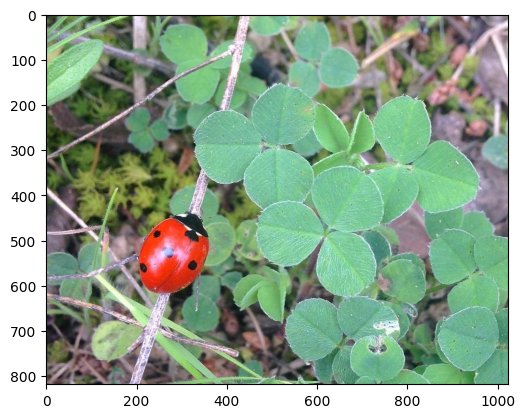

In [3]:
from skimage.io import imread
import os

data_path = r'../../data'
parent_path = os.path.join(data_path, 'ladybugs_SAM')
image_name = os.path.join(parent_path, '620818_780868.jpg')

img = imread(image_name)

plt.imshow(img)

### Call Yolo then SAM

1.  First we call Yolo to get bounding boxes
2.  Then we create a 'StackedLabels' object from the bounding boxes
3.  Then we use the 'StackedLabels' API to segment using 'MobileSAMV2'
4.  Then we order masks largest to smallest.
5.  Now a min projection will show small objects on top (because they have larger indexes. )

In [4]:
results = yolo_detecter.get_results(img, conf=conf, iou= iou, imgsz=imagesz, max_det=10000)
bbs=results[0].boxes.xyxy.cpu().numpy()
stacked_labels = StackedLabels.from_yolo_results(bbs, None, img)
segmented_stacked_labels = segment_from_stacked_labels(stacked_labels, "MobileSamV2")
segmented_stacked_labels.sort_largest_to_smallest()
labels = segmented_stacked_labels.make_2d_labels(type="min")


0: 832x1024 126 objects, 150.6ms
Speed: 6.0ms preprocess, 150.6ms inference, 65.8ms postprocess per image at shape (1, 3, 1024, 1024)


VIT checkpoint loaded successfully


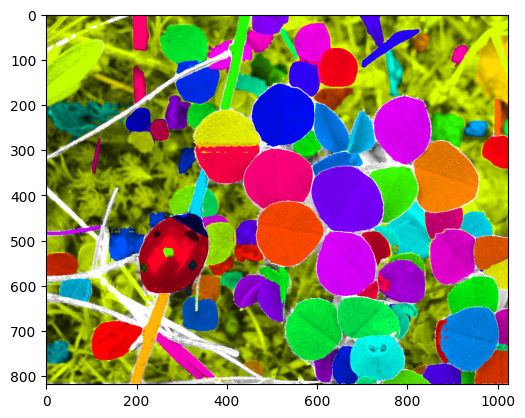

In [5]:
test = mask_overlay(img, labels)

plt.imshow(test, cmap=random_label_cmap())

## View in Napari

... With the ```napari_segment_everything``` widget.

In [8]:

import napari
from  napari_segment_everything import segment_everything

viewer = napari.Viewer()
segment_everything_widget=segment_everything.NapariSegmentEverything(viewer)
viewer.window.add_dock_widget(segment_everything_widget)
segment_everything_widget.load_project(stacked_labels.image, stacked_labels.mask_list)

area 357 838656
label_num 1 126
solidity 1.0 1.0
circularity 0.3928803832138205 0.8653924207805217
mean_intensity 77.3516393442623 226.80461538461537
10th_percentile_intensity 32.99999999999999 185.0
mean_hue 28.668195924939397 193.1675254293533
mean_saturation 28.33593590867213 169.38237657707205
predicted_iou 1 1
stability_score 1 1


In [9]:

viewer = napari.Viewer()
segment_everything_widget=segment_everything.NapariSegmentEverything(viewer)
viewer.window.add_dock_widget(segment_everything_widget)
segment_everything_widget.load_project(segmented_stacked_labels.image, segmented_stacked_labels.mask_list)


area 252.0 454760.0
label_num 1 126
solidity 0.41750943396226414 0.9882313829787234
circularity 0.02318357323121467 0.9606249350277302
mean_intensity 53.47422680412371 226.48439531859557
10th_percentile_intensity 32.0 195.99999999999997
mean_hue 18.968102369780265 222.2363446489838
mean_saturation 18.894646379585843 173.6389744766525
predicted_iou 0.36465099453926086 0.9798977375030518
stability_score 0.6757801175117493 0.991579532623291


In [42]:
layer = viewer.layers['SAM 3D labels']
image_layer = viewer.layers['image']
layer.scale = [10, 1, 1]
layer.translate = [-10*len(segmented_stacked_labels.mask_list), 0, 0]